In [37]:
import numpy as np
np.random.seed(42)
import random
random.seed(42)

import matplotlib.pyplot as plt
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import contingency_matrix
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

def GetTFData():
    comp_categories = ['comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware']
    rec_categories = ['rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey']
    all_categories = comp_categories + rec_categories
        
    twenty_data = fetch_20newsgroups(subset='all', categories=all_categories, shuffle=True, random_state=None)

    vectorizer = TfidfVectorizer(min_df=3, stop_words='english')
    X_data_tfidf = vectorizer.fit_transform(twenty_data.data)

    print("TF-IDF shape:", X_data_tfidf.shape)

    return X_data_tfidf, np.array(twenty_data.target > 3)

def PerformLSA(dataset, r=1000, plot_variance=False):
    svd = TruncatedSVD(n_components=r, random_state=0)
    dataset = svd.fit_transform(dataset)
    if plot_variance:
        accum = np.zeros(r+1)
        for i in range(r):
            accum[i+1] += accum[i] + svd.explained_variance_ratio_[i]
        plt.plot(range(r+1), accum)
        plt.title("Explained variance")
        plt.xlabel("Number of principle components")
        plt.ylabel("Explained variance ratio")
        plt.show()
    return dataset

def PerformNMF(dataset, r=1000):
    model = NMF(n_components=r, init='random', random_state=0)
    dataset = model.fit_transform(dataset)
    return dataset

In [55]:
dataset, data_labels = GetTFData()

TF-IDF shape: (7882, 27768)


In [40]:
km = KMeans(n_clusters=2, random_state=0, max_iter=100, n_init=3)
km.fit(dataset)

print("Contingency Matrix:\n", contingency_matrix(data_labels, km.labels_))

print("Homogeneity: %0.3f" % metrics.homogeneity_score(data_labels, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(data_labels, km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(data_labels, km.labels_))
print("Adjusted Rand-Index: %.3f" % metrics.adjusted_rand_score(data_labels, km.labels_))
print("Adjusted Mutual Information Score: %.3f" % metrics.adjusted_mutual_info_score(data_labels, km.labels_))

Contingency Matrix:
 [[   4 3899]
 [1727 2252]]
Homogeneity: 0.255
Completeness: 0.336
V-measure: 0.290
Adjusted Rand-Index: 0.183
Adjusted Mutual Information Score: 0.290


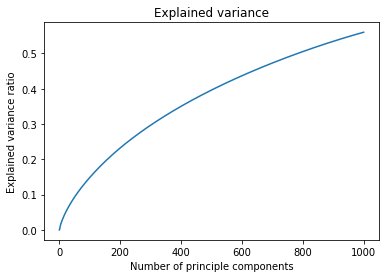

In [41]:
dataset_LSA = PerformLSA(dataset, plot_variance=True)

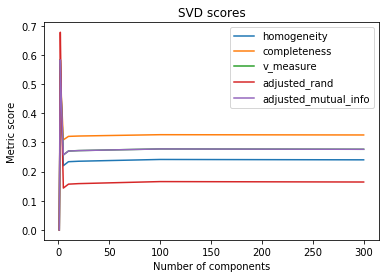

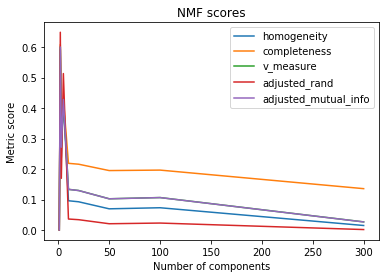

In [42]:
def GetScores(data_labels, km_labels):
    scores = [metrics.homogeneity_score(data_labels, km_labels),
             metrics.completeness_score(data_labels, km_labels),
             metrics.v_measure_score(data_labels, km_labels),
             metrics.adjusted_rand_score(data_labels, km_labels),
             metrics.adjusted_mutual_info_score(data_labels, km_labels)]
    return np.array(scores)

km = KMeans(n_clusters=2, random_state=0, max_iter=100, n_init=3)
rs = [1, 2, 3, 5, 10, 20, 50, 100, 300]
scores = np.zeros((2, len(rs), 5))
for idx, r in enumerate(rs):
    km.fit(dataset_LSA[:, :r])
    scores[0, idx] = GetScores(data_labels, km.labels_)
    dataset_NMF = PerformNMF(dataset, r=r)
    km.fit(dataset_NMF)
    scores[1, idx] = GetScores(data_labels, km.labels_)
    
reds = ['SVD', 'NMF']
metrs = ['homogeneity', 'completeness', 'v_measure', 'adjusted_rand', 'adjusted_mutual_info']
for idx, red in enumerate(reds):
    plt.figure()
    for jdx, met in enumerate(metrs):
        plt.plot(rs, scores[idx, :, jdx], label=met)
    plt.legend()
    plt.title(red + ' scores')
    plt.xlabel("Number of components")
    plt.ylabel("Metric score")
    plt.show()

In [43]:
use_metric = "homogeneity"
jdx = metrs.index(use_metric)
best_svd_r = rs[np.argmax(scores[0, :, jdx])]
best_nmf_r = rs[np.argmax(scores[1, :, jdx])]

print("Best SVD r based on {} score is {}".format(use_metric, best_svd_r))
print("Best NMF r based on {} score is {}".format(use_metric, best_nmf_r))

Best SVD r based on homogeneity score is 2
Best NMF r based on homogeneity score is 2


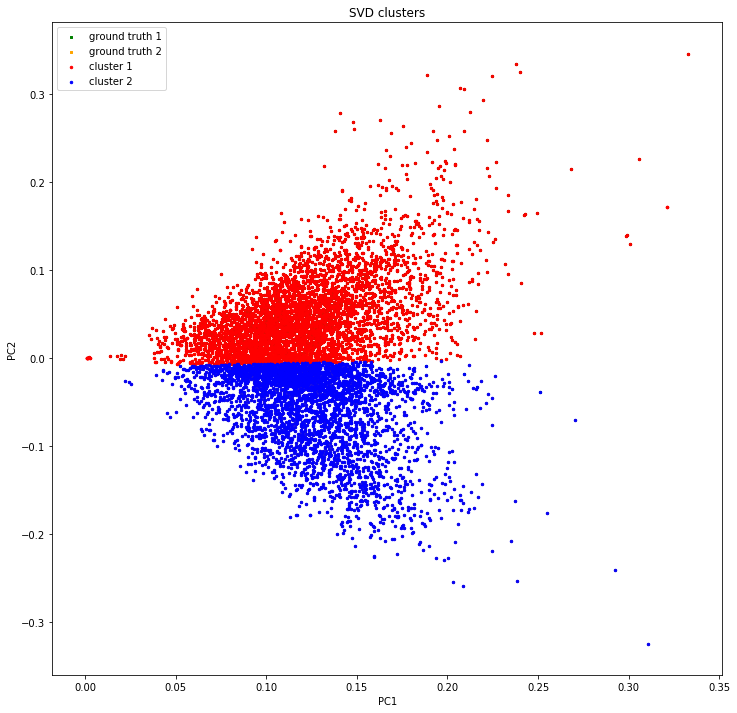

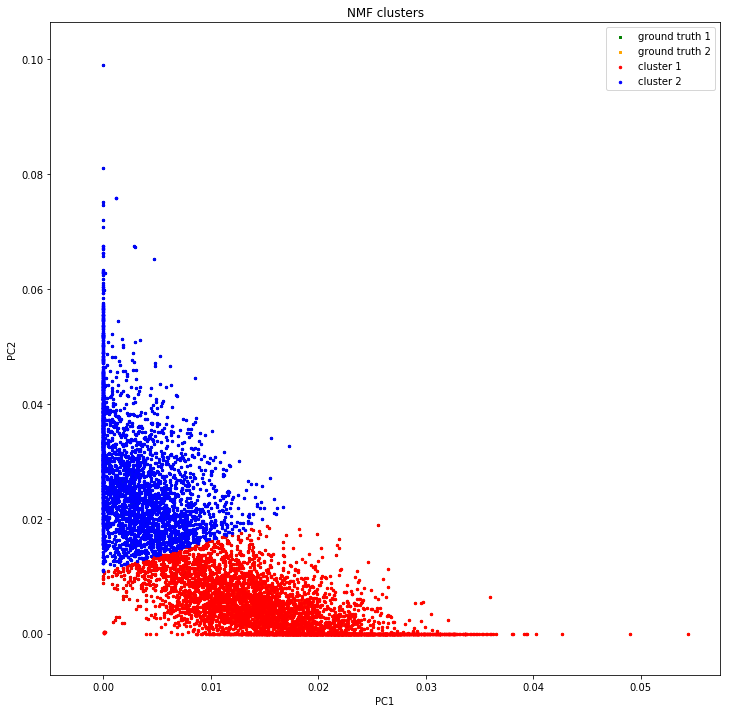

In [46]:
def VisualizeClusters(dataset, data_labels, km_labels, red_type="SVD"):
    plt.figure(figsize=(12,12))
    indexes_0 = []
    indexes_1 = []
    for i, label in enumerate(data_labels):
        if label == 0:
            indexes_0.append(i)
        else:
            indexes_1.append(i)
            
    plt.scatter(dataset[indexes_0, 0], dataset[indexes_0, 1], s=8, marker="s", c='green', label='ground truth 1')
    plt.scatter(dataset[indexes_1, 0], dataset[indexes_1, 1], s=8, marker="s", c='orange', label='ground truth 2')
    
    indexes_0 = []
    indexes_1 = []
    for i, label in enumerate(km_labels):
        if label == 0:
            indexes_0.append(i)
        else:
            indexes_1.append(i)

    plt.scatter(dataset[indexes_0, 0], dataset[indexes_0, 1], s=6, marker="o", c='red', label='cluster 1')
    plt.scatter(dataset[indexes_1, 0], dataset[indexes_1, 1], s=6, marker="o", c='blue', label='cluster 2')
    
    plt.legend()
    plt.title(red_type + " clusters")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.show()

km = KMeans(n_clusters=2, random_state=0, max_iter=1000, n_init=5)

km.fit(dataset_LSA[:, :best_svd_r])
VisualizeClusters(dataset_LSA, data_labels, km.labels_, red_type="SVD")

dataset_NMF = PerformNMF(dataset, r=best_nmf_r)
km.fit(dataset_NMF)
VisualizeClusters(dataset_NMF, data_labels, km.labels_, red_type="NMF")

In [56]:
km = KMeans(n_clusters=2, random_state=0, max_iter=1000, n_init=30)
def VisualizeAndReport(dataset, dataset_labels, red_type="SVD"):
    print("Results for " + red_type)
    km.fit(dataset)
    VisualizeClusters(dataset, dataset_labels, km.labels_, red_type=red_type)
    print(metrs)
    print(GetScores(dataset_labels, km.labels_))
    print()
    
dataset_NMF = PerformNMF(dataset, r=best_nmf_r)
scaler = StandardScaler(with_mean=False)
dataset_LSA_unit_var = scaler.fit_transform(dataset_LSA[:, :best_svd_r])
dataset_NMF_unit_var = scaler.fit_transform(dataset_NMF)

eps = 0.005
dataset_NMF_nonlinear = np.log(dataset_NMF + eps)
dataset_NMF_unit_var_nonlinear = scaler.fit_transform(dataset_NMF_nonlinear)

Results for SVD without scaling


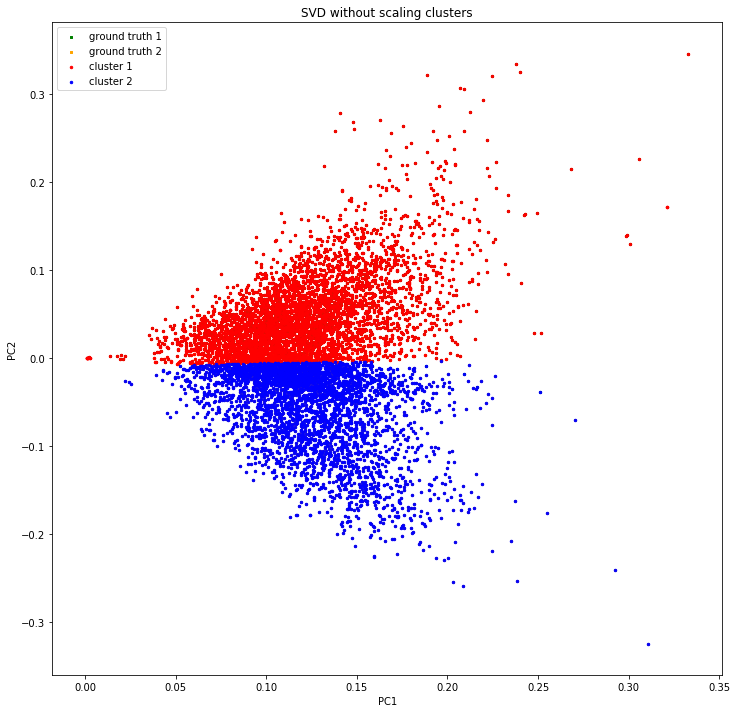

['homogeneity', 'completeness', 'v_measure', 'adjusted_rand', 'adjusted_mutual_info']
[0.58512798 0.58724415 0.58618416 0.68254349 0.5861462 ]



In [48]:
VisualizeAndReport(dataset_LSA[:, :best_svd_r], data_labels, red_type="SVD without scaling")

Results for SVD with scaling


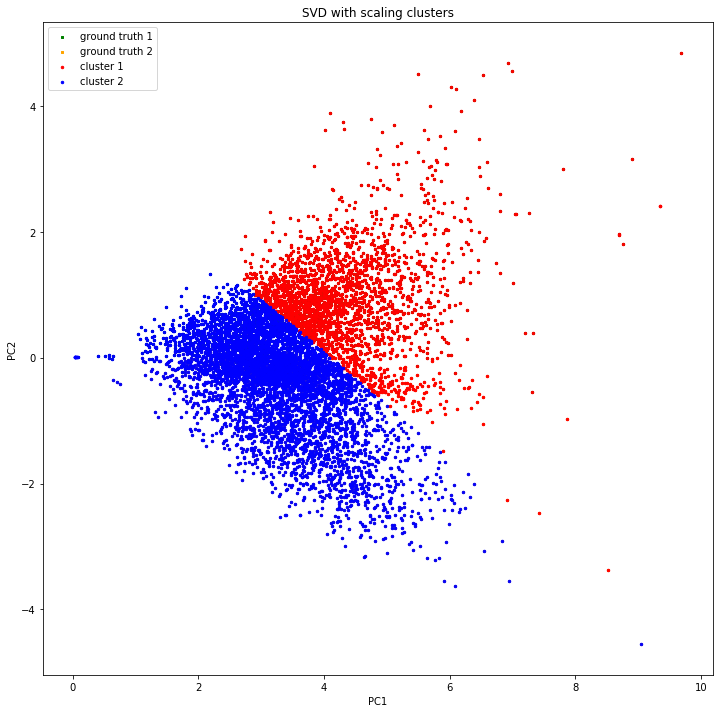

['homogeneity', 'completeness', 'v_measure', 'adjusted_rand', 'adjusted_mutual_info']
[0.22615238 0.25559819 0.23997539 0.2424785  0.23990155]



In [10]:
VisualizeAndReport(dataset_LSA_unit_var, data_labels, red_type="SVD with scaling")

Results for NMF without scaling


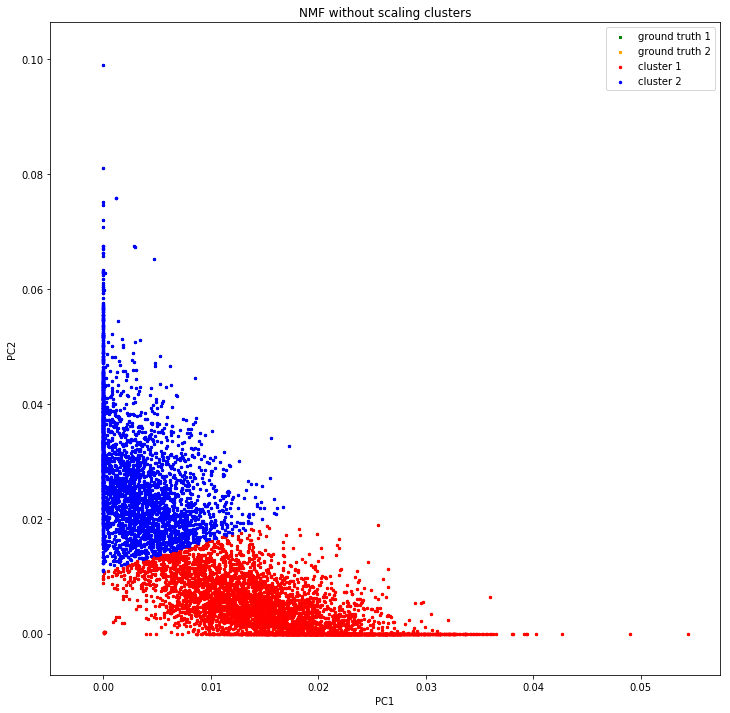

['homogeneity', 'completeness', 'v_measure', 'adjusted_rand', 'adjusted_mutual_info']
[0.59284452 0.60806716 0.60035936 0.64859172 0.60032231]



In [49]:
VisualizeAndReport(dataset_NMF, data_labels, red_type="NMF without scaling")

Results for NMF with scaling


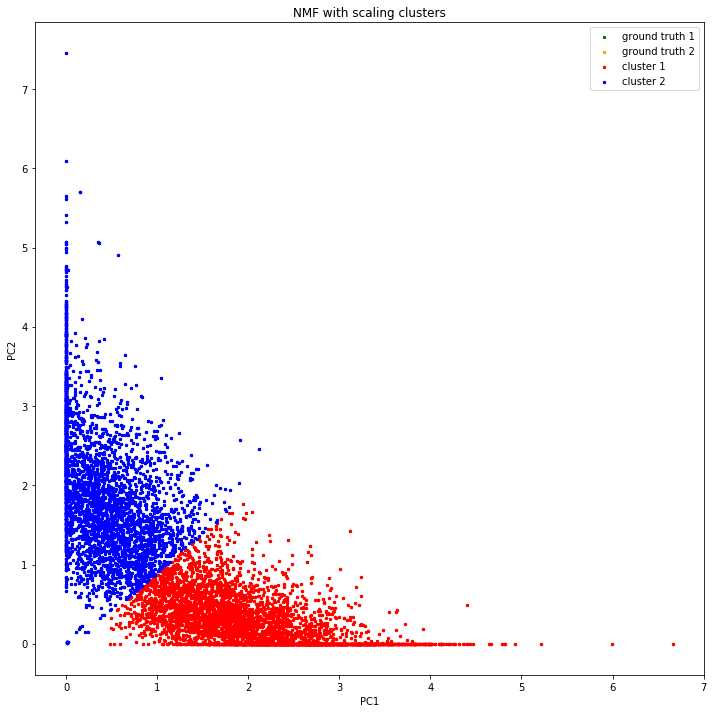

['homogeneity', 'completeness', 'v_measure', 'adjusted_rand', 'adjusted_mutual_info']
[0.68350057 0.6862689  0.68488194 0.77433569 0.68485303]



In [50]:
VisualizeAndReport(dataset_NMF_unit_var, data_labels, red_type="NMF with scaling")

Results for NMF with non-linearity


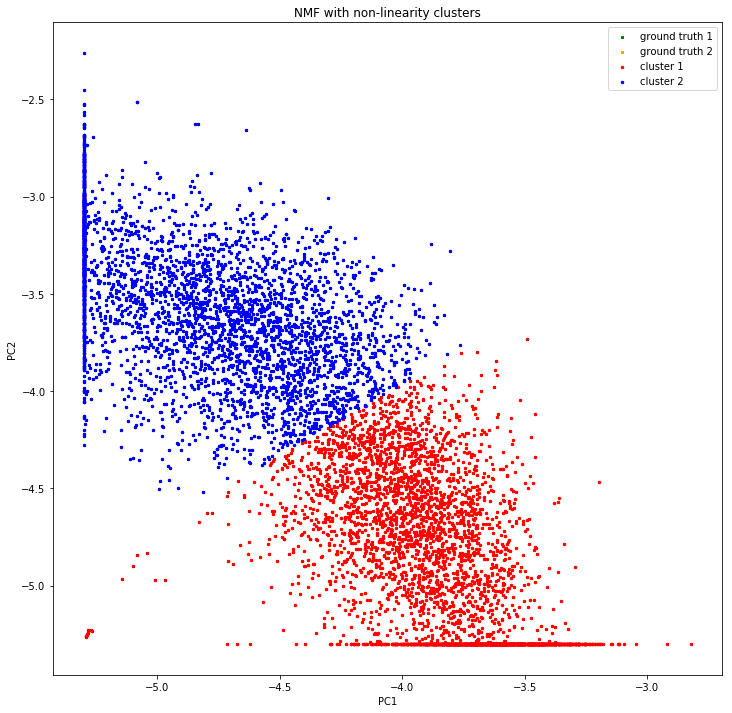

['homogeneity', 'completeness', 'v_measure', 'adjusted_rand', 'adjusted_mutual_info']
[0.70930358 0.70954106 0.7094223  0.80591552 0.70939569]



In [51]:
VisualizeAndReport(dataset_NMF_nonlinear, data_labels, red_type="NMF with non-linearity")

Results for NMF with scaling and non-linearity


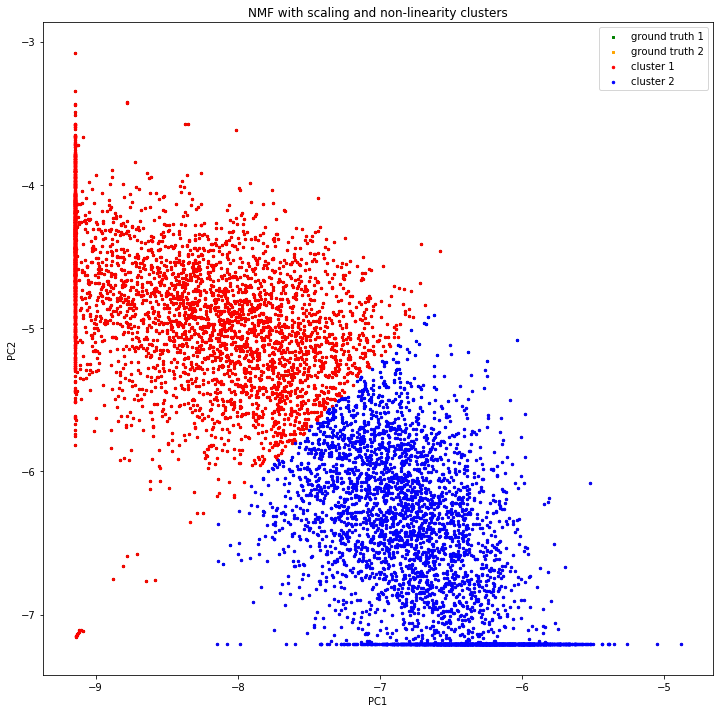

['homogeneity', 'completeness', 'v_measure', 'adjusted_rand', 'adjusted_mutual_info']
[0.70215497 0.70301876 0.7025866  0.79773472 0.70255935]



In [58]:
VisualizeAndReport(dataset_NMF_unit_var_nonlinear, data_labels, red_type="NMF with scaling and non-linearity")

In [ ]:
#Part 2 yay!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

C:\Users\AJ\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
C:\Users\AJ\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()


original image is (1024, 1548, 3)
image matrix is (1585152, 2)
[1 1 1 ... 1 1 1]


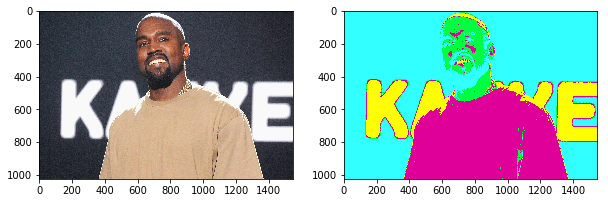

In [63]:
#part 3

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img=mpimg.imread('C:/Users/AJ/Desktop/kanye.jpg')

#imgplot = plt.imshow(img)

R = img[:,:,0]
G = img[:,:,1]
B = img[:,:,2]


r= R/(R+G+B)
g= G/(R+G+B)

norm_im=np.zeros((r.shape[0],r.shape[1],2))
norm_im[:,:,0] = r
norm_im[:,:,1]=g

img_mat = norm_im.reshape((-1,2))
img_mat=np.nan_to_num(img_mat)
img_mat[img_mat > 1e10] = 300


print('original image is', img.shape)
print('image matrix is', img_mat.shape)




from sklearn.cluster import KMeans
#im_clust = KMeans(n_clusters=4,n_init=30, max_iter=1000, random_state=0).fit(img_mat)
im_clust = KMeans(n_clusters=4,n_init=30, max_iter=1000, random_state=0).fit(img.reshape(img.shape[0]*img.shape[1],3))
print(im_clust.labels_)

labs = im_clust.labels_

new_im=np.zeros((r.shape[0]*r.shape[1],3))

for i, lab in enumerate(labs):
    
    if lab == 0:
        pix = np.array([223,0,153])
    elif lab == 1:
        pix = np.array([50,255,255])
    elif lab == 2:
        pix = np.array([255,255,0])
    elif lab == 3:
        pix = np.array([0,255,65])
    elif lab == 4:
        pix = np.array([255,153,0])
    elif lab == 5:
        pix = np.array([200,100,100])
    
    new_im[i,:]=pix

    
disp_im = new_im.reshape((r.shape[0],r.shape[1],3))

#imgplot = plt.imshow(disp_im/255)

fig=plt.figure(figsize=(10,12))
fig.add_subplot(1, 2, 1)
plt.imshow(img)
fig.add_subplot(1, 2, 2)
plt.imshow(disp_im/255)
plt.show()